# 6.6.6 Keras Challenge - Detecting Planes in Satelite Images
Now take your Keras skills and go build another neural network. Pick your data set, but it should be one of abstract types, possibly even nonnumeric, and use Keras to make five implementations of your network. Compare them both in computational complexity as well as in accuracy and given that tradeoff decide which one you like best.

Your dataset should be sufficiently large for a neural network to perform well (samples should really be in the thousands here) and try to pick something that takes advantage of neural networks’ ability to have both feature extraction and supervised capabilities, so don’t pick something with an easy to consume list of features already generated for you (though neural networks can still be useful in those contexts).

Note that if you want to use an unprocessed image dataset, scikit-image is a useful package for converting to importable numerics.

The [dataset](https://www.kaggle.com/rhammell/planesnet/data) contains satelite imagery, and the goal is to detect the presence of a plane. 

In [1]:
import tensorflow as tf
import keras

C:\Users\Loren\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import glob
import numpy as np
import pandas as pd
import os.path as path
from scipy import misc
import imageio
import matplotlib.pyplot as plt

%matplotlib inline 

In [3]:
# Get paths for each image
img_path = r"..\unit_6\planesnet"
file_paths = glob.glob(path.join(img_path, '*.png'))

In [4]:
# Load the images
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)

In [5]:
# display image size
images.shape

(32000, 20, 20, 3)

In [6]:
# Normalize values to 1 from 0 to 255 (256 values of pixels)
images = images / 255

In [7]:
# retrieve labels
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [48]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.20)

In [49]:
# Print sample sizes
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(25600, 20, 20, 3) train samples
(6400, 20, 20, 3) test samples


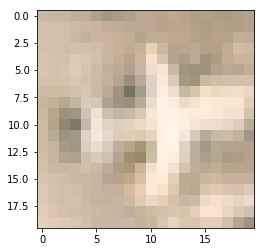

In [50]:
# Display image
plt.imshow(x_train[0])
plt.show()

## Modeling

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD

# Import the backend
from keras import backend as K

In [52]:
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])
image_size[0], image_size[1], image_size[2]

(20, 20, 3)

In [53]:
#Reshaping to a flattened version
x_flat_train = x_train.reshape(x_train.shape[0], 20*20*3)
x_flat_test = x_test.reshape(x_test.shape[0], 20*20*3)

#Encoding the output
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print('Original Sizes:', x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print('Flattened:', x_flat_train.shape, x_flat_test.shape)

Original Sizes: (25600, 20, 20, 3) (6400, 20, 20, 3) (25600, 2) (6400, 2)
Flattened: (25600, 1200) (6400, 1200)


#### 1. Multi Layer Perceptron, simple sequential model

In [35]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(64, activation='relu', input_shape=(x_flat_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

#model.add(Flatten())
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(2, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              #optimizer=RMSprop(),
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 64)                76864     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 130       
Total params: 81,154
Trainable params: 81,154
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(x_flat_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_flat_test, y_test))
score = model.evaluate(x_flat_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25600/25600 [==============================] - 2s 77us/step - loss: 0.5142 - acc: 0.7564 - val_loss: 0.4030 - val_acc: 0.8127
Epoch 2/10
25600/25600 [==============================] - 1s 54us/step - loss: 0.3973 - acc: 0.8148 - val_loss: 0.3424 - val_acc: 0.8348
Epoch 3/10
25600/25600 [==============================] - 1s 54us/step - loss: 0.3777 - acc: 0.8319 - val_loss: 0.3502 - val_acc: 0.8428
Epoch 4/10
25600/25600 [==============================] - 2s 60us/step - loss: 0.3444 - acc: 0.8442 - val_loss: 0.3223 - val_acc: 0.8216
Epoch 5/10
25600/25600 [==============================] - 2s 60us/step - loss: 0.3108 - acc: 0.8614 - val_loss: 0.2840 - val_acc: 0.8709
Epoch 6/10
25600/25600 [==============================] - 2s 62us/step - loss: 0.3357 - acc: 0.8538 - val_loss: 0.2966 - val_acc: 0.8841
Epoch 7/10
25600/25600 [==============================] - 1s 55us/step - loss: 0.3201 - acc: 0.8601 - val_loss: 0.3686 - val_acc:

#### 2. Multi Layer Perceptron, with added layers

In [31]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(128, activation='relu', input_shape=(x_flat_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

#model.add(Flatten())
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(2, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               153728    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 130       
Total para

In [34]:
history = model.fit(x_flat_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_flat_test, y_test))
score = model.evaluate(x_flat_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25600/25600 [==============================] - 2s 93us/step - loss: 0.2741 - acc: 0.8815 - val_loss: 0.2998 - val_acc: 0.8573
Epoch 2/10
25600/25600 [==============================] - 2s 94us/step - loss: 0.2678 - acc: 0.8853 - val_loss: 0.4181 - val_acc: 0.8075
Epoch 3/10
25600/25600 [==============================] - 2s 96us/step - loss: 0.2594 - acc: 0.8903 - val_loss: 0.2223 - val_acc: 0.9123
Epoch 4/10
25600/25600 [==============================] - 2s 90us/step - loss: 0.2638 - acc: 0.8853 - val_loss: 0.2400 - val_acc: 0.9038
Epoch 5/10
25600/25600 [==============================] - 2s 89us/step - loss: 0.2525 - acc: 0.8936 - val_loss: 0.3510 - val_acc: 0.8430
Epoch 6/10
25600/25600 [==============================] - 2s 90us/step - loss: 0.2626 - acc: 0.8853 - val_loss: 0.2281 - val_acc: 0.9094
Epoch 7/10
25600/25600 [==============================] - 2s 95us/step - loss: 0.2529 - acc: 0.8934 - val_loss: 0.3225 - val_acc:

#### .915 accuracy.

### 3. CNN

In [44]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(20, 20, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25600/25600 [==============================] - 41s 2ms/step - loss: 0.4615 - acc: 0.7902 - val_loss: 0.2596 - val_acc: 0.8877
Epoch 2/10
25600/25600 [==============================] - 41s 2ms/step - loss: 0.2267 - acc: 0.9085 - val_loss: 0.1425 - val_acc: 0.9453
Epoch 3/10
25600/25600 [==============================] - 40s 2ms/step - loss: 0.1640 - acc: 0.9361 - val_loss: 0.1110 - val_acc: 0.9555
Epoch 4/10
25600/25600 [==============================] - 41s 2ms/step - loss: 0.1295 - acc: 0.9500 - val_loss: 0.1034 - val_acc: 0.9598
Epoch 5/10
25600/25600 [==============================] - 40s 2ms/step - loss: 0.1089 - acc: 0.9584 - val_loss: 0.0858 - val_acc: 0.9659
Epoch 6/10
25600/25600 [==============================] - 40s 2ms/step - loss: 0.1034 - acc: 0.9627 - val_loss: 0.0783 - val_acc: 0.9703
Epoch 7/10
25600/25600 [==============================] - 42s 2ms/step - loss: 0.0909 - acc: 0.9668 - val_loss: 0.0795 - val_acc:

### 4. CNN with additional dense layer and smaller batch size.

In [55]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(20, 20, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25600/25600 [==============================] - 46s 2ms/step - loss: 0.4368 - acc: 0.8036 - val_loss: 0.2095 - val_acc: 0.9136
Epoch 2/10
25600/25600 [==============================] - 45s 2ms/step - loss: 0.1986 - acc: 0.9230 - val_loss: 0.1281 - val_acc: 0.9511
Epoch 3/10
25600/25600 [==============================] - 44s 2ms/step - loss: 0.1467 - acc: 0.9433 - val_loss: 0.1133 - val_acc: 0.9581
Epoch 4/10
25600/25600 [==============================] - 44s 2ms/step - loss: 0.1225 - acc: 0.9543 - val_loss: 0.0925 - val_acc: 0.9631
Epoch 5/10
25600/25600 [==============================] - 45s 2ms/step - loss: 0.1058 - acc: 0.9617 - val_loss: 0.0711 - val_acc: 0.9759
Epoch 6/10
25600/25600 [==============================] - 45s 2ms/step - loss: 0.0922 - acc: 0.9657 - val_loss: 0.0782 - val_acc: 0.9714
Epoch 7/10
25600/25600 [==============================] - 44s 2ms/step - loss: 0.0832 - acc: 0.9709 - val_loss: 0.0722 - val_acc:

#### .982 accuracy

#### CNN with 25 epochs

In [56]:
# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(20, 20, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=25,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 25600 samples, validate on 6400 samples
Epoch 1/25
25600/25600 [==============================] - 44s 2ms/step - loss: 0.4055 - acc: 0.8188 - val_loss: 0.1977 - val_acc: 0.9169
Epoch 2/25
25600/25600 [==============================] - 42s 2ms/step - loss: 0.1814 - acc: 0.9310 - val_loss: 0.2421 - val_acc: 0.9025
Epoch 3/25
25600/25600 [==============================] - 43s 2ms/step - loss: 0.1366 - acc: 0.9481 - val_loss: 0.1670 - val_acc: 0.9316
Epoch 4/25
25600/25600 [==============================] - 43s 2ms/step - loss: 0.1094 - acc: 0.9597 - val_loss: 0.0990 - val_acc: 0.9648
Epoch 5/25
25600/25600 [==============================] - 43s 2ms/step - loss: 0.0936 - acc: 0.9665 - val_loss: 0.0726 - val_acc: 0.9730
Epoch 6/25
25600/25600 [==============================] - 43s 2ms/step - loss: 0.0854 - acc: 0.9699 - val_loss: 0.0595 - val_acc: 0.9794
Epoch 7/25
25600/25600 [==============================] - 43s 2ms/step - loss: 0.0724 - acc: 0.9744 - val_loss: 0.0620 - val_acc:

#### .987 accuracy

### Pretrained model

In [57]:
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
 
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')
 
#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

17227776/17225924 [==============================] - 3s 0us/step


In [59]:
file_paths[0]

'..\\unit_6\\planesnet\\0__20140723_181317_0905__-122.073653222_37.7090043618.png'

PIL image size (224, 224)


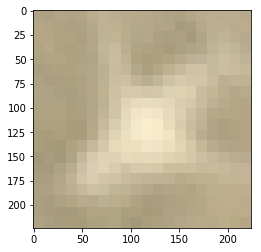

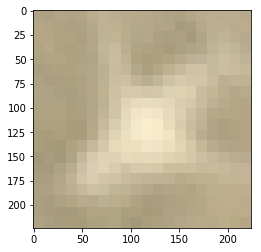

numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)


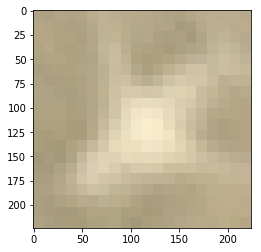

In [78]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
 
filename = file_paths[30000]
# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()
 
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [79]:
# prepare the image for the VGG model
processed_image = vgg16.preprocess_input(image_batch.copy())
 
# get the predicted probabilities for each class
predictions = vgg_model.predict(processed_image)
# print predictions
 
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
label = decode_predictions(predictions)
print(label)

40960/35363 [==================================] - 0s 1us/step
[[('n04548280', 'wall_clock', 0.06821078), ('n04209239', 'shower_curtain', 0.039430827), ('n03888257', 'parachute', 0.021995947), ('n02782093', 'balloon', 0.021237824), ('n03532672', 'hook', 0.013352058)]]


### Conclusion
The pretrained model doesn't work on the dataset photos as they have been reduced down to grainy blobs, probably to make training a lot faster. Out of the models from scratch, the 4th model I believe is the best one, it had an accuracy of .982 and it trained a lot faster than model 5. 